In [ ]:
# Conditional GAN Keras Implementation with MNIST Handwritten Dataset





In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

[[[-0.01103785  0.01951322]
  [-0.03553444  0.00885229]
  [-0.04601275  0.02539185]
  [ 0.02419673 -0.04055291]
  [-0.03295226  0.03068577]
  [-0.01086426  0.01841683]
  [-0.00560058 -0.02728554]
  [-0.03258815  0.03140659]
  [-0.00389151  0.03831175]
  [-0.00476296  0.03108031]]]


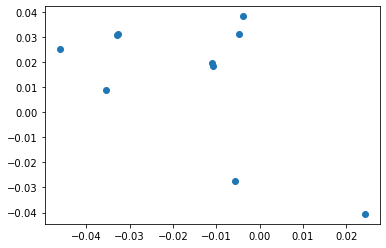

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

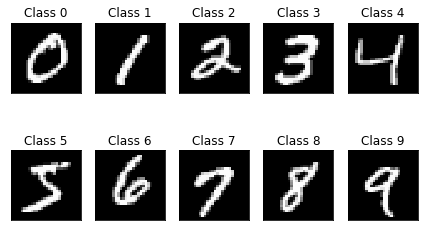

In [5]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [6]:
print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

In [8]:

# prints a summary representation of your model
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [9]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

In [10]:

# prints a summary representation of your model
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding_1[0][0]                
______________________________________________________________________________________________

In [11]:

# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

In [12]:

# prints a summary representation of your model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [13]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

In [14]:

# prints a summary representation of your model
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           embedding_2[0][0]                
____________________________________________________________________________________________

In [15]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [16]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0


In [17]:
# prints a summary representation of your model
d_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            273441      model[1][0]                

epoch = 1/100, d_loss=0.668, g_loss=0.932                                                                                                                      


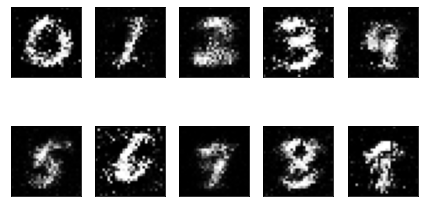

epoch = 2/100, d_loss=0.684, g_loss=0.836                                                                                                                      
epoch = 3/100, d_loss=0.680, g_loss=0.820                                                                                                                                                                                                                                                                                                                                
epoch = 4/100, d_loss=0.682, g_loss=0.825                                                                                                                      
epoch = 5/100, d_loss=0.668, g_loss=0.814                                                                                                                                                                                                                           
epoch = 6/100, d_loss=0.694, g_loss=0.816                

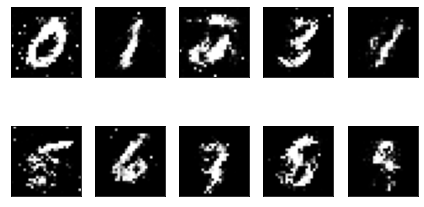

epoch = 12/100, d_loss=0.640, g_loss=0.897                                                                                                                                                                                                                           
epoch = 13/100, d_loss=0.659, g_loss=0.860                                                                                                                      
epoch = 14/100, d_loss=0.659, g_loss=0.911                                                                                                                      
epoch = 15/100, d_loss=0.659, g_loss=0.912                                                                                                                                                                                                                           
epoch = 16/100, d_loss=0.640, g_loss=0.924                                                                                                                

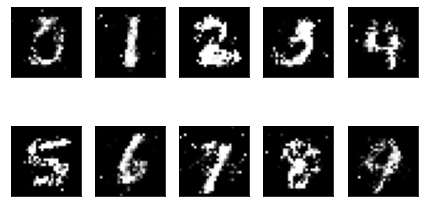

epoch = 22/100, d_loss=0.636, g_loss=0.926                                                                                                                                                                                                                                                                                                                                
epoch = 23/100, d_loss=0.665, g_loss=0.864                                                                                                                      
epoch = 24/100, d_loss=0.618, g_loss=0.938                                                                                                                      
epoch = 25/100, d_loss=0.638, g_loss=0.933                                                                                                                                                                                                                           
epoch = 26/100, d_loss=0.647, g_loss=0.911           

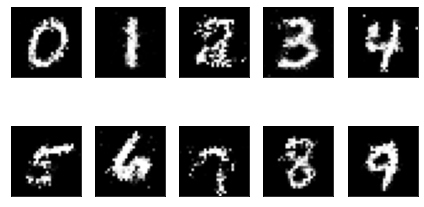

epoch = 32/100, d_loss=0.630, g_loss=0.935                                                                                                                                                                                                                                                                                                                                                                                                                                     
epoch = 33/100, d_loss=0.650, g_loss=0.893                                                                                                                      
epoch = 34/100, d_loss=0.646, g_loss=0.929                                                                                                                      
epoch = 35/100, d_loss=0.698, g_loss=0.953                                                                                                                                                                            

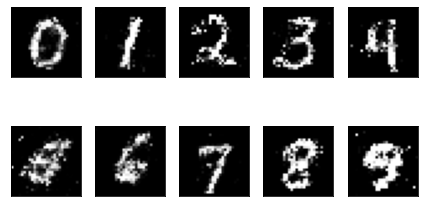

epoch = 42/100, d_loss=0.660, g_loss=0.956                                                                                                                      
epoch = 43/100, d_loss=0.672, g_loss=0.912                                                                                                                      
epoch = 44/100, d_loss=0.668, g_loss=0.852                                                                                                                      
epoch = 45/100, d_loss=0.701, g_loss=0.872                                                                                                                      
epoch = 46/100, d_loss=0.644, g_loss=0.898                                                                                                                                                                                                                           
epoch = 47/100, d_loss=0.645, g_loss=0.927                                                    

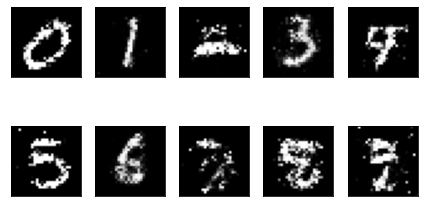

epoch = 52/100, d_loss=0.712, g_loss=0.919                                                                                                                      
epoch = 53/100, d_loss=0.668, g_loss=0.917                                                                                                                      
epoch = 54/100, d_loss=0.651, g_loss=0.968                                                                                                                      
epoch = 55/100, d_loss=0.651, g_loss=0.923                                                                                                                                                                                                                                                                                                                               
epoch = 56/100, d_loss=0.666, g_loss=0.872                                                                                                                 

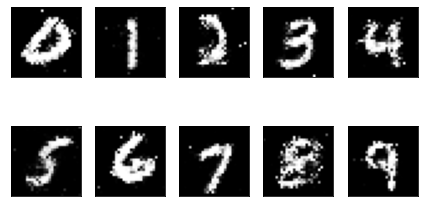

epoch = 62/100, d_loss=0.644, g_loss=0.967                                                                                                                                                                                                                           
epoch = 63/100, d_loss=0.696, g_loss=0.913                                                                                                                      
epoch = 64/100, d_loss=0.648, g_loss=0.910                                                                                                                      
epoch = 65/100, d_loss=0.652, g_loss=0.902                                                                                                                      
epoch = 66/100, d_loss=0.645, g_loss=0.896                                                                                                                      
epoch = 67/100, d_loss=0.664, g_loss=0.899                                                    

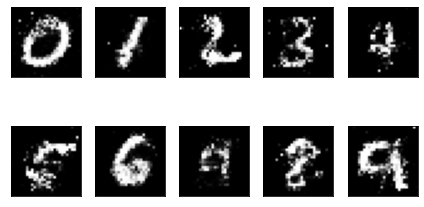

epoch = 72/100, d_loss=0.669, g_loss=0.886                                                                                                                                                                                                                          
epoch = 73/100, d_loss=0.672, g_loss=0.886                                                                                                                                                                                                                                                                                                                                
epoch = 74/100, d_loss=0.683, g_loss=0.940                                                                                                                      
epoch = 75/100, d_loss=0.677, g_loss=0.932                                                                                                                      
epoch = 76/100, d_loss=0.675, g_loss=0.897            

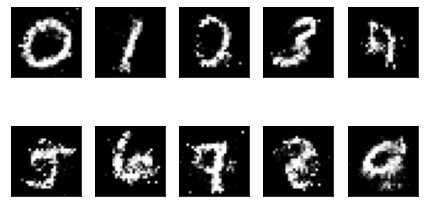

epoch = 82/100, d_loss=0.654, g_loss=0.881                                                                                                                      
epoch = 83/100, d_loss=0.656, g_loss=0.912                                                                                                                      
epoch = 84/100, d_loss=0.692, g_loss=0.913                                                                                                                                                                                                                           
epoch = 85/100, d_loss=0.673, g_loss=0.889                                                                                                                      
epoch = 86/100, d_loss=0.686, g_loss=0.929                                                                                                                                                                                                                     

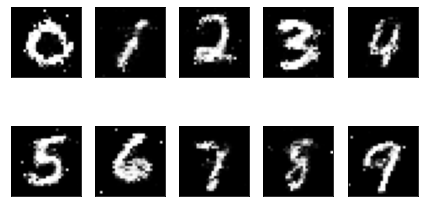

epoch = 92/100, d_loss=0.645, g_loss=0.852                                                                                                                                                                                                                           
epoch = 93/100, d_loss=0.664, g_loss=0.966                                                                                                                      
epoch = 94/100, d_loss=0.693, g_loss=0.878                                                                                                                      
epoch = 95/100, d_loss=0.654, g_loss=0.888                                                                                                                      
epoch = 96/100, d_loss=0.681, g_loss=0.932                                                                                                                      
epoch = 97/100, d_loss=0.660, g_loss=0.916                                                    

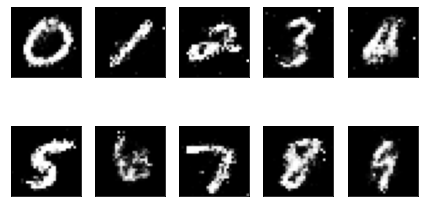

In [18]:

epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

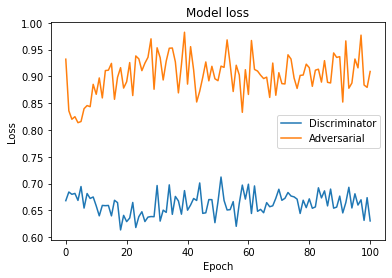

In [19]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()